In [65]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import time

import asd
import xmlheader_parse
import idxfile_parse
import ping_datablock_parse
import proc_trace

def plot_seismic_traces():
    pass


idx_file2 = r'C:\YandexDisk\MyProjects\InspectingP70Data\P70_data\SEB\PS3SLF_2021-09-17T110351Z_00047728.asd.acf.idx'
acf_file2 = r'C:\YandexDisk\MyProjects\InspectingP70Data\P70_data\SEB\PS3SLF_2021-09-17T110351Z_00047728.asd.acf'


idx_file = r'C:\YandexDisk\MyProjects\InspectingP70Data\P70_data\SEB\PS3SLF_2022-06-17T054120Z_04061504.asd.acf.idx'
acf_file = r'C:\YandexDisk\MyProjects\InspectingP70Data\P70_data\SEB\PS3SLF_2022-06-17T054120Z_04061504.asd.acf'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
asd_obj_list = asd.ASDfile.create_from_idx_file(idx_file2)
asd_obj = asd_obj_list[0]

with open(acf_file2, 'rb') as f1:
    buffer = f1.read()
    
    
traces = []
start_times = []

delay = 0.010  # s; 10 ms
trace_len = 0.15  # s; 150 ms

num_of_traces = 0
for obj in asd_obj_list[:50]:
    xmlheader_parse.parse_xml_header(obj, buffer)
    ping_datablock_parse.parse_bin_header(obj, buffer)
    
    # print(f'Num of Soundings: {len(obj.soundings)}')
    # print(f'Is draught corrected: ' + asd_obj.general.is_draught_corrected)

    for sounding in obj.soundings[:]:
        # print(sounding.ampl_time_rel2trg)
        # print(sounding.ampl_scan_interval*1000)
        # print(f'Sounding heave corrected: {sounding.heave_correction}')
        # print(f'Source Level: {sounding.src_level} dB')
        # print(f'Transmission Voltage: {sounding.voltage} V')
        # print(f'sample unit: {sounding.ampl_notation}')
        
        ampls, times = proc_trace.proc_trace(sounding, obj, sample_dt=1)
    


In [ ]:
import segyio
from conv_to_segy import MySpec



_____SEG-Y FILE____

Sample format: 4-byte IEEE float
Sample count: 320
Trace count: 3053
DELAY (109 byte): 19
3053
3053


Trace(traces = 3053, samples = 320)
320
[[   0.            0.          -74.01425171 ... -189.865448
  -200.73365784   54.69252014]
 [   0.            0.           11.12300777 ...  194.94602966
   121.75128937 -148.33201599]
 [   0.            0.           19.32768822 ...   56.50496674
   248.49093628   82.02179718]
 ...
 [   0.            0.            0.         ... -369.64953613
  -221.88348389  226.32746887]
 [   0.            0.            0.         ... -261.41812134
    16.51138687  -24.8022728 ]
 [   0.            0.            0.         ...  495.62460327
   322.11602783 -195.45895386]]


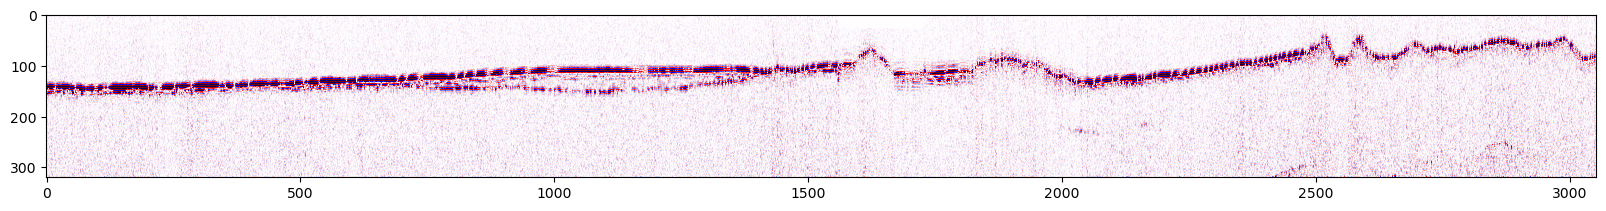

In [48]:
import segyio
from conv_to_segy import MySpec

def plot_rawtraces(raw_traces):
    clip = 1e+3
    vmin, vmax = -clip, clip

    # Figure
    figsize=(20, 20)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize, facecolor='w', edgecolor='k',
                        squeeze=False,
                        sharex=True)
    axs = axs.ravel()
    im = axs[0].imshow(raw_traces.T, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)
    plt.show()


path_to_save = r'C:\YandexDisk\MyProjects\InspectingP70Data\P70_data\test.sgy'
path = r'C:\YandexDisk\MyProjects\InspectingP70Data\P70_data\Profile-0_W1_SLF2109171103_LL_car.sgy'


with segyio.open(filename=path, mode="r",
                            strict = False,
                            ignore_geometry = True,
                            endian = 'big') as f:
    # print(np.shape(f.trace.raw[:]))
    # plot_rawtraces(f.trace.raw[:])
    
    print('\n_____SEG-Y FILE____\n')
    
    print(f'Sample format: {f.format}')
    print(f'Sample count: {len(f.samples)}')
    print(f'Trace count: {f.tracecount}')
    
    
    # modes are: .trace, .header, .iline/xline, .fast/slow, .depth_slice
    # .gather, .text, .bin
    
    # 2D seismic profiles are unstructured files
    # .trace and .header are the only modes available for unstructured files
    # traces are enumerated: 0..len(f.trace)
    # .trace mode - offers raw adressing of traces as they are laid out in the file
    # Reading a trace yields a numpy ndarray, and
    # reading multiple traces yields a generator of ndarray's
    
    # .header mode - accessing items yield header objects instead of numpy ndarray
    # Headers are dict-like objects, where
    # keys are integers, seismic unix-style keys and segyio enums
    
    # print(f'{f.bin}')
    # print(f.text[0])
    print(f'DELAY (109 byte): {f.header[0]['109']}')
    print(len(f.header))
    print(len(f.trace))
    print('\n')
    print(f.trace)
    print(f.header)
    print(len(f.samples))
    # print(type(np.fromiter(f.trace[:])))
    print(np.fromiter(f.trace[:], dtype=np.dtype((float, len(f.samples)))))
    plot_rawtraces(np.fromiter(f.trace[:], dtype=np.dtype((float, len(f.samples)))))